In [1]:
import pyodbc
import sqlalchemy
import dotenv
import os

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import axline
import seaborn as sns

from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor, LinearRegression, RANSACRegressor, ElasticNetCV, TheilSenRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor, ExtraTreesRegressor

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import keras
from scikeras.wrappers import KerasRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator

dotenv.load_dotenv()

sql_server = os.getenv('SQL_SERVER')
db_conn_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={sql_server};DATABASE=japan;Trusted_Connection=yes;'
connection_url = sqlalchemy.engine.URL.create(
    "mssql+pyodbc", 
    query={"odbc_connect": db_conn_string}
)
engine = sqlalchemy.create_engine(connection_url)
df_japan = pd.read_sql('SELECT * FROM Transactions', engine)

print(df_japan.head())

columns_to_encode = ['RealEstateType', 'Region', 'Prefecture', 'City', 'District', 'FrontageRoadType', 'FrontageRoadDirection', 'LandShape', 'PlanningType']
# Floorplan, CurrentUsage, PostTransactionUsage, Structure, BuildingYear either drop or input with unknown
columns_to_drop = ['ID', 'NearestStation', 'TransactionQuarter', 'Price', 'UnitPrice', 'FloorArea']
tentative_columns = ['FloorPlan', 'CurrentUsage', 'PostTransactionUsage', 'Structure', 'BuildingYear']
numerical_values = ['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'GreatArea', 'GreatFloorArea', 'FrontageRoadBreadth', 'PrewarBuilding', 'MaximumBuildingCoverageRatio', 'TransactionYear']

price = df_japan['Price']

df_japan = df_japan.drop(columns=columns_to_drop)
df_japan = df_japan.drop(columns=tentative_columns)
print(df_japan.info())
print(df_japan.drop(columns=columns_to_encode).info())

df_japan = pd.get_dummies(df_japan, columns=columns_to_encode)
print(df_japan.info())
print(df_japan.shape)

X_train, X_test, y_train, y_test = train_test_split(df_japan, price, test_size=0.2)

       ID  RealEstateType  Region  Prefecture  City  District  NearestStation  \
0  435310              56    46.0          20   373   38907.0          2807.0   
1  435311              56    46.0          20   373   38907.0          2807.0   
2  435312              56    46.0          20   373   38907.0          2807.0   
3  435313              56    46.0          20   373   38173.0          2810.0   
4  435314              56    46.0          20   373   38173.0          2793.0   

   MinTimeToNearestStation  MaxTimeToNearestStation       Price  ...  \
0                     21.0                     21.0   4000000.0  ...   
1                     26.0                     26.0  21000000.0  ...   
2                     26.0                     26.0  10000000.0  ...   
3                     13.0                     13.0  12000000.0  ...   
4                      9.0                      9.0  37000000.0  ...   

   LandShape  BuildingYear  PrewarBuilding  Structure  CurrentUsage  \
0      11

RidgeCV()
score:  0.22003273496312903


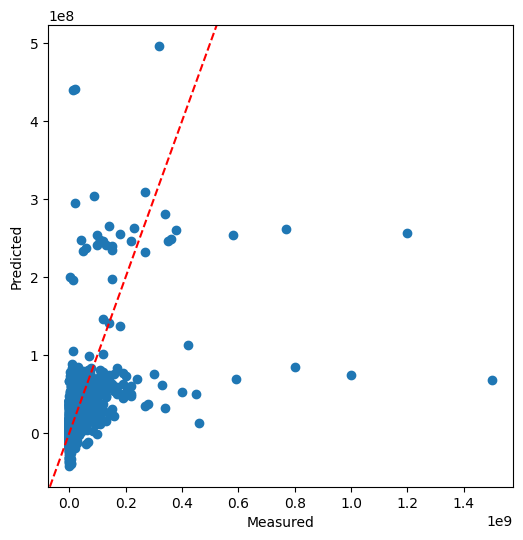

LarsCV()
score:  0.22884242277409794


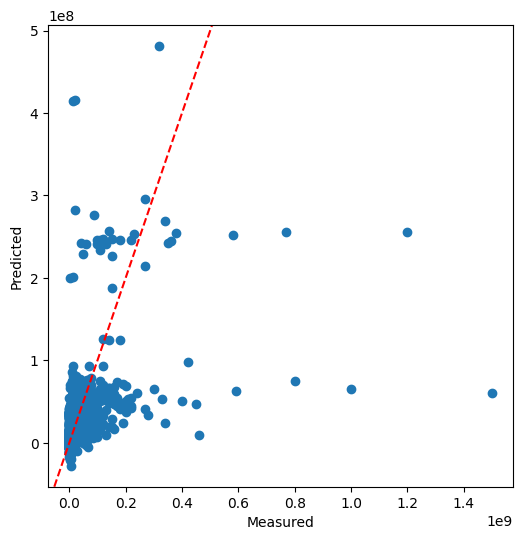

OrthogonalMatchingPursuitCV()
score:  0.21683401339643626


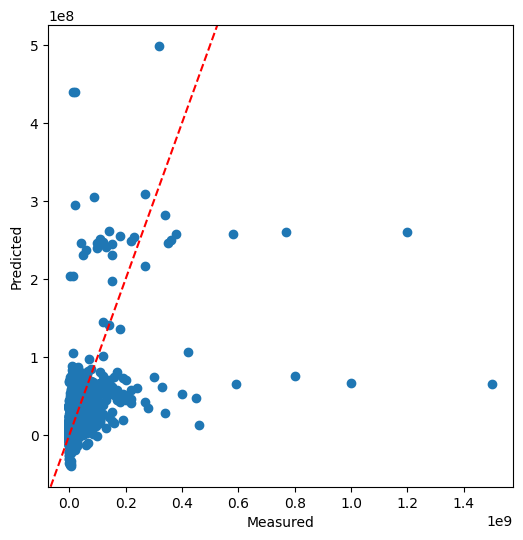

i:\miniconda\envs\inz--ai\Lib\site-packages\sklearn\linear_model\_glm\glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor()
score:  0.6188782862779798


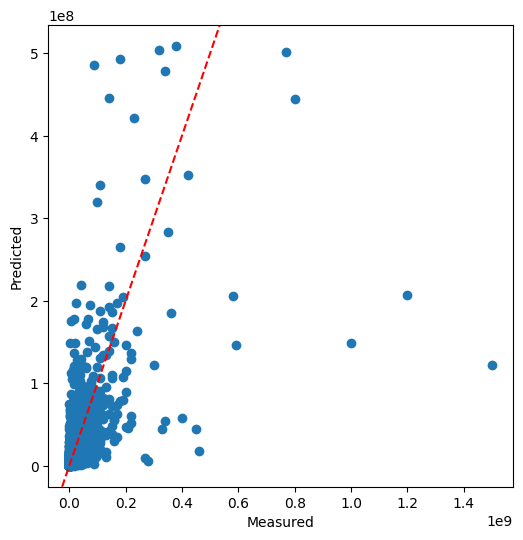

GammaRegressor()
score:  0.4886662357173198


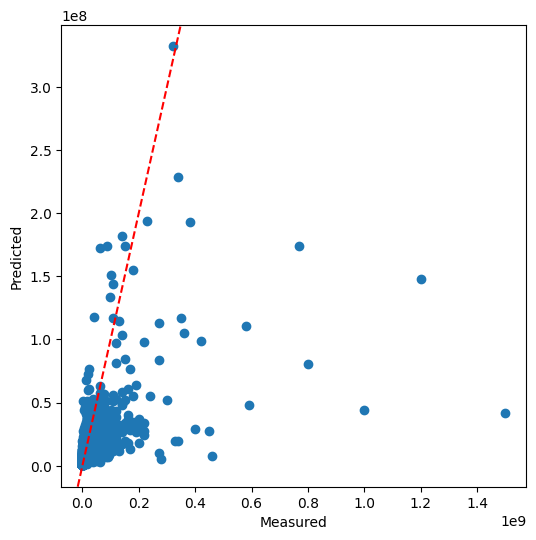

BayesianRidge()
score:  0.23198606004030242


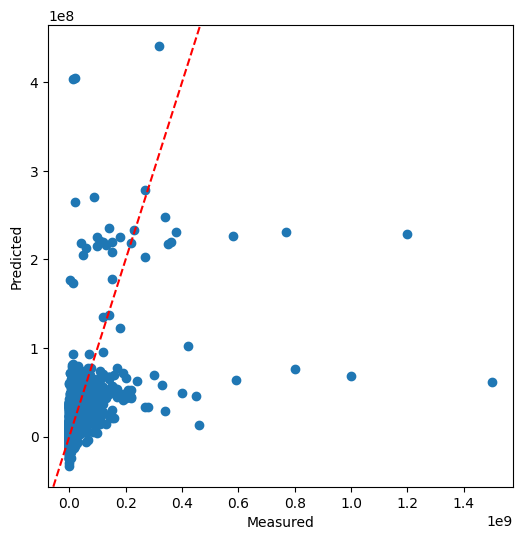

SGDRegressor()
score:  -3084643139.033133


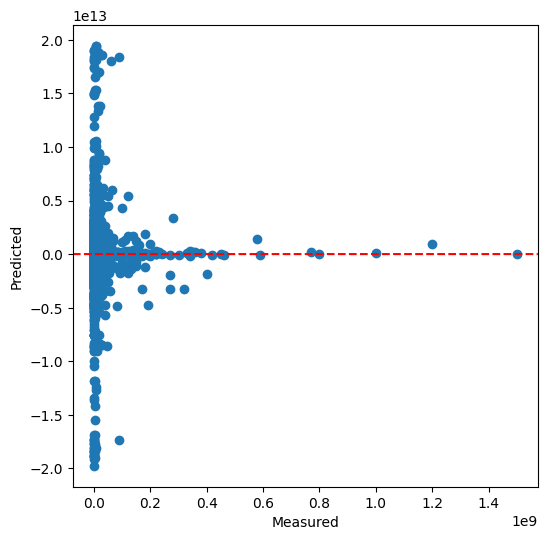

In [ ]:
from sklearn.linear_model import RidgeCV, LarsCV, OrthogonalMatchingPursuitCV, HuberRegressor, PoissonRegressor, GammaRegressor, BayesianRidge 

new_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', RidgeCV())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LarsCV())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', OrthogonalMatchingPursuitCV())
    ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', HuberRegressor())
    # ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', PoissonRegressor())
    ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GammaRegressor())
    ]),
    #  Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', ARDRegression())
    # ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', BayesianRidge())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', SGDRegressor())
    ]), 
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TheilSenRegressor())
    ]),
]

for model in new_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

TweedieRegressor(max_iter=1500, power=2)
score:  0.4916387830817567


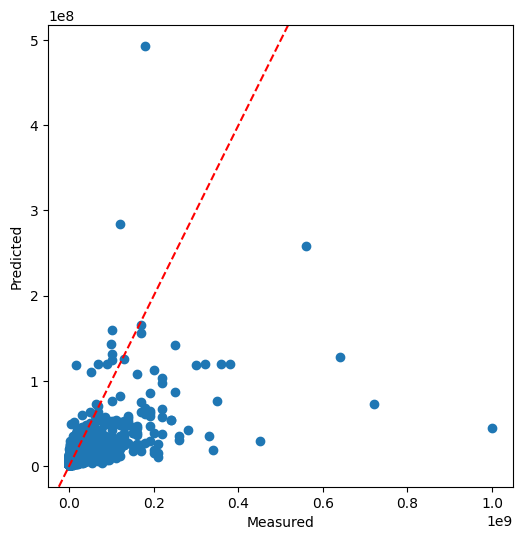

TweedieRegressor(max_iter=3000, power=1)
score:  0.6209304649833027


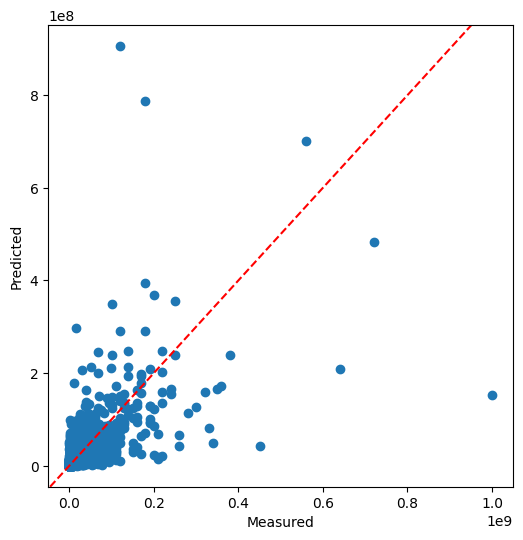

PoissonRegressor(max_iter=3000)
score:  0.6209304649833027


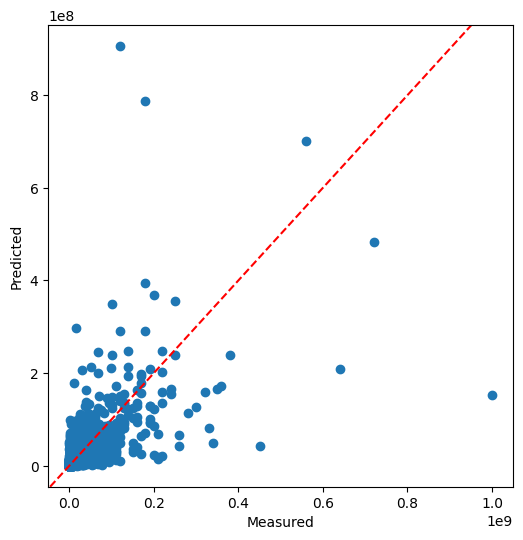

ExtraTreesRegressor()
score:  -0.30999802809194765


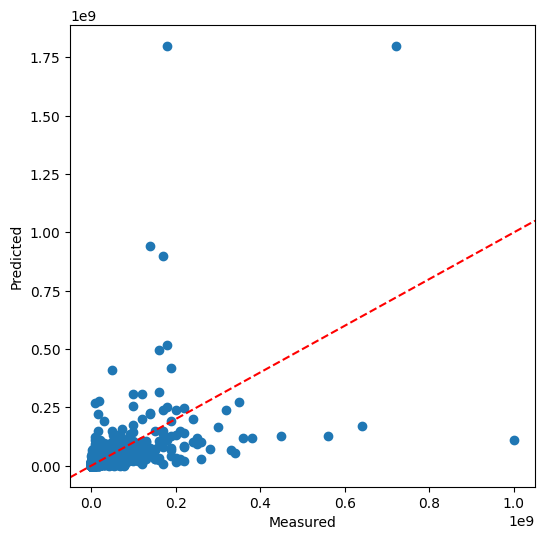

In [5]:
from sklearn.linear_model import TweedieRegressor, PoissonRegressor
from sklearn.ensemble import ExtraTreesRegressor

new2_list_of_models = [
    #  Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor())
    # ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor(power=3))
    # ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor(power=1.2, max_iter=500))
    # ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=2, max_iter=1500))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=1, max_iter=3000))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', PoissonRegressor(max_iter=3000))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', ExtraTreesRegressor())
    ]),
]

for model in new2_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

RANSACRegressor()
score:  -3.044602925907668e+26


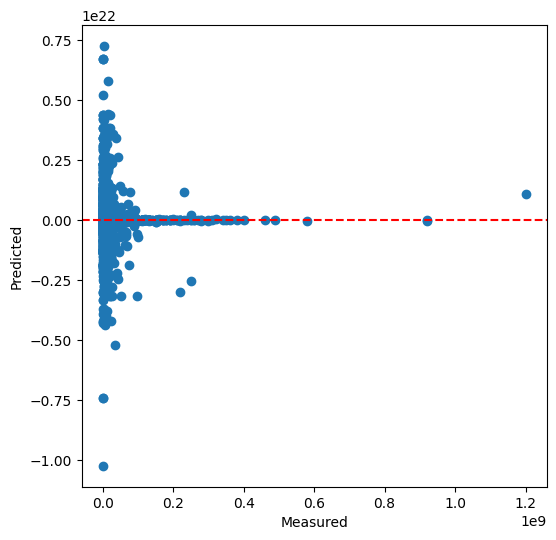

In [3]:
new3_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', RANSACRegressor())
    ]),
]

for model in new3_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

LassoLarsCV()
score:  0.33292687724810865


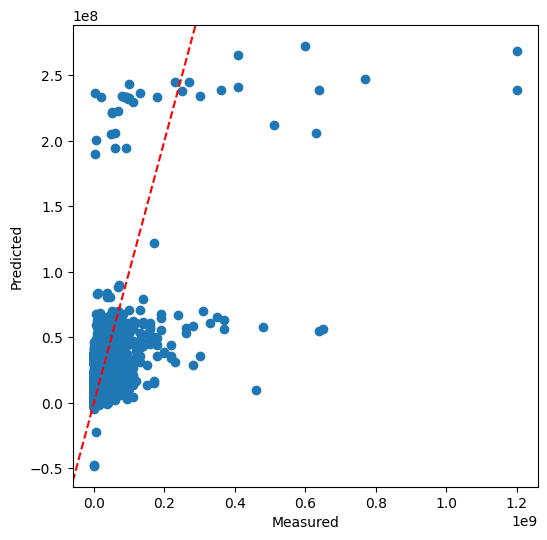

In [4]:
from sklearn.linear_model import LassoLarsCV

new3_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LassoLarsCV())
    ]),
]

for model in new3_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

StackingRegressor(cv=5,
                  estimators=[('gb_reg', GradientBoostingRegressor()),
                              ('dnn_reg',
                               KerasRegressor(epochs=50, model=<function build_dnn at 0x000001F63F1B2FC0>, verbose=False)),
                              ('gamma_reg', GammaRegressor()),
                              ('poisson_reg', PoissonRegressor(max_iter=3000)),
                              ('tweedie1_reg',
                               TweedieRegressor(max_iter=3000, power=1)),
                              ('tweedie2_reg',
                               TweedieRegressor(max_iter=1500, power=2))],
                  final_estimator=GradientBoostingRegressor(), n_jobs=-1)
score:  0.42316465156782845


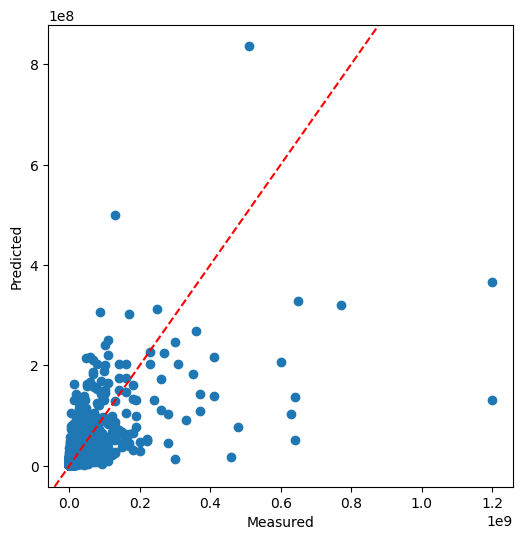

In [7]:
from sklearn.linear_model import GammaRegressor, PoissonRegressor, TweedieRegressor
from sklearn.ensemble import StackingRegressor

def build_dnn(meta): 
    model= keras.models.Sequential([
                    keras.layers.Dense(200,activation='leaky_relu', input_dim=meta["n_features_in_"]),
                    keras.layers.LayerNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(600,activation='leaky_relu'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(200,activation='leaky_relu'),
                    keras.layers.Dense(100,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(50,activation='leaky_relu'),
                    keras.layers.Dense(1, activation='linear')
        ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])
    return model

def run_model_4():
    gb_reg = GradientBoostingRegressor()
    gamma_reg = GammaRegressor()
    poisson_reg = PoissonRegressor(max_iter=3000)
    tweedie1_reg = TweedieRegressor(power=1, max_iter=3000)
    tweedie2_reg = TweedieRegressor(power=2, max_iter=1500)
    dnn_reg = KerasRegressor(build_dnn, epochs=50, verbose=False)
    estimators = [ ('gb_reg', gb_reg), ('dnn_reg', dnn_reg),
                  ('gamma_reg', gamma_reg), ('poisson_reg', poisson_reg), ('tweedie1_reg', tweedie1_reg), ('tweedie2_reg', tweedie2_reg)]
    stacking_reg = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(), cv=5, n_jobs=-1)

    model = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', stacking_reg)
    ])

    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

run_model_4()